In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

import os
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import random

Mounted at /content/gdrive


In [ ]:
PATH = '/content/gdrive/My Drive/data/'
BUFFER_SIZE = 50
BATCH_SIZE  = 1
IMG_WIDTH   = 1024
IMG_HEIGHT  = 256

def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)    
    
    # resize
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    
    # copy
    gray = tf.identity(image)
    color= tf.identity(image)
    
    # convert to gray
    gray = tf.image.rgb_to_grayscale(gray)
    
    gray  = tf.cast(gray, tf.float32)
    color = tf.cast(color, tf.float32) 

    return gray, color

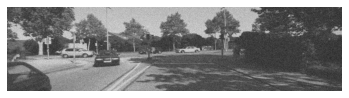

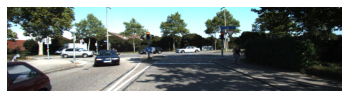

In [ ]:
image = load(PATH+'unet/kitti_train/000008_10.png')

# casting to int for matplotlib to show the image
plt.figure()
plt.axis('off')
plt.imshow(image/255.0)

In [ ]:
# normalizing the images to [-1, 1]
def normalize(gray, color):
    gray  = (gray / 127.5) - 1
    color = (color / 127.5) - 1

    return gray, color

def random_jitter(gray, color):
    if tf.random.uniform(()) > 0.5:
        # random mirroring
        gray  = tf.image.flip_left_right(gray)
        color = tf.image.flip_left_right(color)

    return gray, color

def load_image_train(image_file):
    gray, color = load(image_file)
    gray, color = random_jitter(gray, color)
    gray, color = normalize(gray, color)

    return gray, color

def load_image_test(image_file):
    gray, color = load(image_file)
    gray, color = normalize(gray, color)

    return gray, color

In [ ]:
# train_dataset
train_dataset = tf.data.Dataset.list_files(PATH+'unet/kitti_train/*_10.png')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

# test_dataset
test_dataset = tf.data.Dataset.list_files(PATH+'unet/kitti_test/0000*_10.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

In [ ]:
def extract_first_features(filters, size):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    
    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.ReLU())

    return result

def downsample(filters, size):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.ReLU())

    return result

def upsample(filters, size):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.ReLU())

    return result

In [ ]:
def UNet_process(x):
    down_stack = [
        downsample(64, 4),  # (bs, 64, 128, 64)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
    ]

    up_stack = [
        upsample(512, 4), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    OUTPUT_CHANNELS = 3
    
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 512, 512, 3)

    concat = tf.keras.layers.Concatenate()
    
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])

    x = last(x)
    
    return x
    
def Generator(): 
    # multiple inputs
    inputs = tf.keras.layers.Input(shape=[256, 1024, 1])    
    x = inputs

    # extract_first_features
    fextract = extract_first_features(64, 3)
    x = fextract(x) # (1,256,1024,64)
       
    # UNet_process
    fake_color = UNet_process(x)

    return tf.keras.Model(inputs=[inputs], outputs=[fake_color])

In [ ]:
generator = Generator()
generator.summary()

#generator = tf.keras.models.load_model('/content/gdrive/My Drive/Model/1.L1+GAN_23.93321418762207.h5')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 1024, 1 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256, 1024, 64 832         input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128, 512, 64) 65792       sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 64, 256, 256) 263168      sequential_1[0][0]               
______________________________________________________________________________________________

In [ ]:
def compute_l1_loss(img1, img2):
  return tf.reduce_mean(tf.abs(img1-img2))

img1 = tf.random.normal((1, IMG_HEIGHT, IMG_WIDTH, 3))
img2 = tf.random.normal((1, IMG_HEIGHT, IMG_WIDTH, 3))
l1_loss = compute_l1_loss(img1, img2)
print(l1_loss.numpy())

1.1275192


In [ ]:
def compute_loss(fake_l, target_l):    
    l1_loss = compute_l1_loss(fake_l, target_l) 
    return l1_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

In [ ]:
def evaluate(model, epoch):  
    psnr_mean = 0.0
    count = 0
    for gray, real in test_dataset:
        fake = model([gray], training=True)
         
        psnr = tf.image.psnr(fake*0.5 + 0.5, real*0.5 + 0.5, max_val=1.0)

        __psnr_mean = tf.math.reduce_mean(psnr)
        
        psnr_mean += __psnr_mean
        count =count + 1
    
    psnr_mean = psnr_mean/count
    print('-------- psnr: ', psnr_mean.numpy(), '   ----- epoch: ', epoch, '  count: ', count)
    
    return psnr_mean
    
def generate_images(model, gray, real):
    fake = model([gray], training=True)
    plt.figure(figsize=(15,20))
    
    display_list = [gray[0,:,:,0], real[0], fake[0]]
    title = ['Input Left', 'Real Left', 'Predicted Left']    

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()        

In [ ]:
@tf.function
def train_step(gray, color):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # output
        fake_color = generator([gray], training=True)
        loss = compute_loss(fake_color, color)

    generator_gradients = gen_tape.gradient(loss, generator.trainable_variables)    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    
    return loss    
    
def fit(train_ds, epochs, test_ds):
    best_pnsr = 0.0
    for epoch in range(epochs):
        start = time.time()        
       
        # Train
        for gray, color in train_ds:
           loss = train_step(gray, color)
        
        pnsr = evaluate(generator, epoch)        
        if best_pnsr < pnsr:
            best_pnsr = pnsr
            print(best_pnsr)
            #generator.save('/content/gdrive/My Drive/data/unet/21.2_{}.h5'.format(epoch+1))
             
            for gray, color in test_ds.take(1):
                generate_images(generator, gray, color)


-------- psnr:  21.184553    ----- epoch:  0   count:  100
tf.Tensor(21.184553, shape=(), dtype=float32)


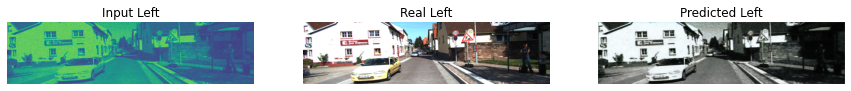

-------- psnr:  22.287476    ----- epoch:  1   count:  100
tf.Tensor(22.287476, shape=(), dtype=float32)


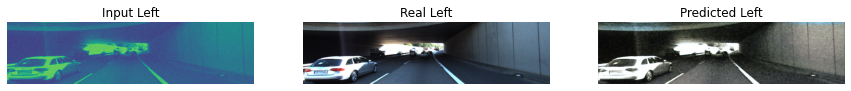

-------- psnr:  22.671246    ----- epoch:  2   count:  100
tf.Tensor(22.671246, shape=(), dtype=float32)


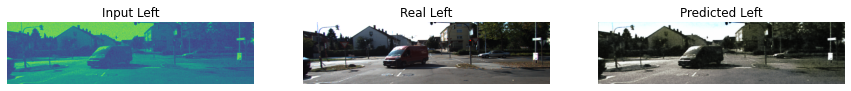

-------- psnr:  22.76028    ----- epoch:  3   count:  100
tf.Tensor(22.76028, shape=(), dtype=float32)


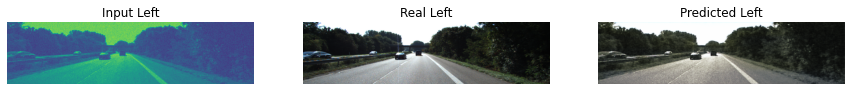

-------- psnr:  23.276287    ----- epoch:  4   count:  100
tf.Tensor(23.276287, shape=(), dtype=float32)


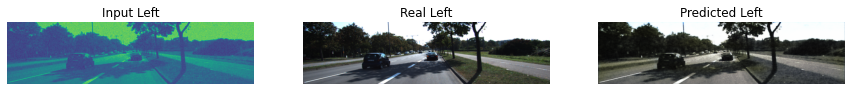

-------- psnr:  23.261208    ----- epoch:  5   count:  100
-------- psnr:  23.283049    ----- epoch:  6   count:  100
tf.Tensor(23.283049, shape=(), dtype=float32)


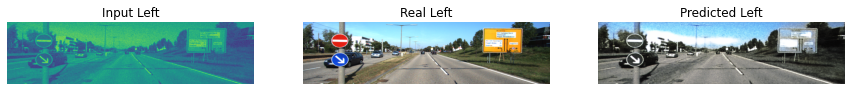

-------- psnr:  23.340437    ----- epoch:  7   count:  100
tf.Tensor(23.340437, shape=(), dtype=float32)


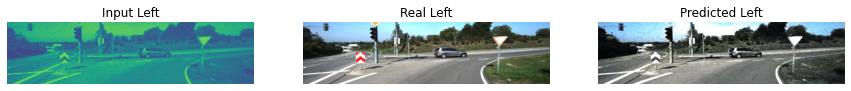

-------- psnr:  23.623568    ----- epoch:  8   count:  100
tf.Tensor(23.623568, shape=(), dtype=float32)


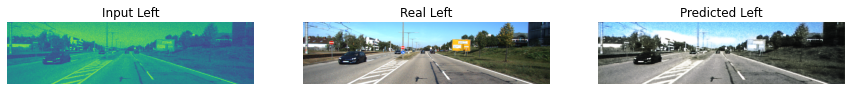

-------- psnr:  23.150236    ----- epoch:  9   count:  100
-------- psnr:  23.860918    ----- epoch:  10   count:  100
tf.Tensor(23.860918, shape=(), dtype=float32)


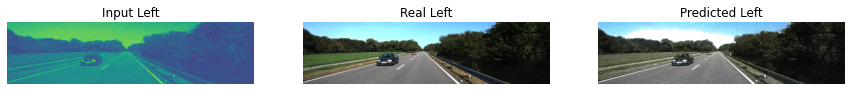

-------- psnr:  23.223059    ----- epoch:  11   count:  100
-------- psnr:  23.670294    ----- epoch:  12   count:  100
-------- psnr:  23.452103    ----- epoch:  13   count:  100
-------- psnr:  23.61248    ----- epoch:  14   count:  100
-------- psnr:  23.96587    ----- epoch:  15   count:  100
tf.Tensor(23.96587, shape=(), dtype=float32)


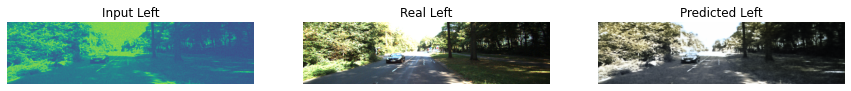

-------- psnr:  24.22733    ----- epoch:  16   count:  100
tf.Tensor(24.22733, shape=(), dtype=float32)


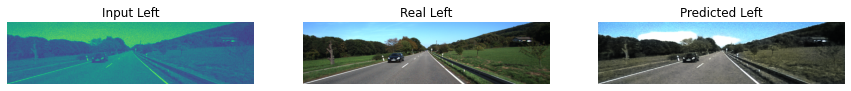

-------- psnr:  23.646399    ----- epoch:  17   count:  100
-------- psnr:  24.020987    ----- epoch:  18   count:  100
-------- psnr:  23.400328    ----- epoch:  19   count:  100
-------- psnr:  24.207632    ----- epoch:  20   count:  100
-------- psnr:  23.953768    ----- epoch:  21   count:  100
-------- psnr:  24.025341    ----- epoch:  22   count:  100
-------- psnr:  23.97984    ----- epoch:  23   count:  100
-------- psnr:  24.03404    ----- epoch:  24   count:  100
-------- psnr:  23.963238    ----- epoch:  25   count:  100
-------- psnr:  24.381443    ----- epoch:  26   count:  100
tf.Tensor(24.381443, shape=(), dtype=float32)


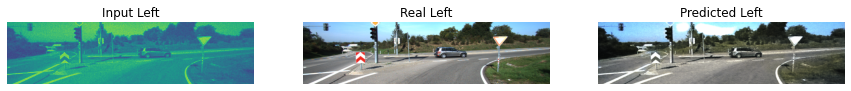

-------- psnr:  23.657282    ----- epoch:  27   count:  100
-------- psnr:  24.35823    ----- epoch:  28   count:  100


In [ ]:
EPOCHS = 30
fit(train_dataset, EPOCHS, test_dataset)

In [ ]:
new_model = tf.keras.models.load_model('/content/gdrive/My Drive/data/unet/21.2_10.h5')

# Show the model architecture
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 1024, 1 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256, 1024, 64 832         input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128, 512, 64) 65792       sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 64, 256, 256) 263168      sequential_1[0][0]               
______________________________________________________________________________________________

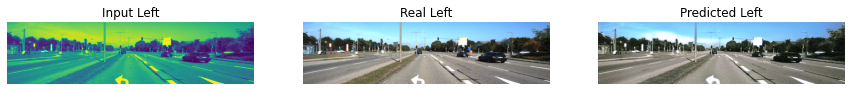

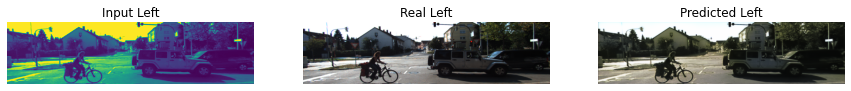

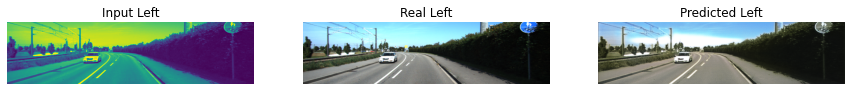

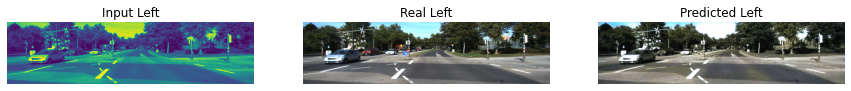

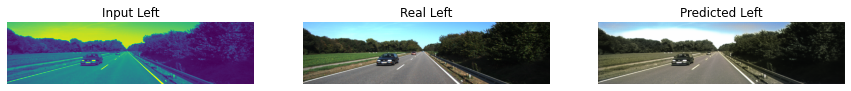

In [ ]:
for inp, tar in test_dataset.take(5):
  generate_images(new_model, inp, tar)